In this notebook, we can load directly the output of notebook 1. Here, we first do some QC and make plots to check the raw counts per cell, coverage per site etc. We then convert the raw counts to percentages, and the percentages to allele counts. Information is stored in several dataframes that can be used in downstream analyses such as the tree building. We only have to compute the dataframes once.

# Import all relevant packages

In [1]:
#import all 
%matplotlib inline
import matplotlib
import sys, os
from pandas.io.parsers import read_csv
import numpy as np
import seaborn as sns
import pandas as pd
import sklearn.cluster as cluster
import matplotlib.pyplot as plt
import collections
import scipy
import itertools
#import floweaver
np.warnings.filterwarnings('ignore')
import pysam
import pyBigWig as bw
#%load_ext rpy2.ipython
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Read in dataframe

#### This is necessary for computing percentages and later allele counts. If these are already computed and saved, move down to 'load computed datasets'.

In [2]:
pathToData = '/Users/m.blotenburg/Documents/Projects/Mouse_Scartrace/Data_analysis/Scar_analysis/20200414_VAN2988_remap_BWAfilters_AlleleCalling_maskedGenome/'

In [3]:
df = pd.read_pickle(pathToData + '120hAA_miseq_remapped_SQfiltered.pickle.gz')
df.head()

gastruloid                           C5A9                                    \
cell                                 A2_1 A2_10 A2_100 A2_101 A2_102 A2_103   
chrom allele site      scar                                                   
1     None   12847807  WT             NaN   NaN    NaN    NaN    NaN    NaN   
             12847810  WT             NaN   NaN    NaN    NaN    NaN    NaN   
             12847812  WT             NaN   NaN    NaN    NaN    NaN    NaN   
             143473230 143473407.D    NaN   NaN    NaN    NaN    NaN    NaN   
             143473231 T.143473171.I  NaN   NaN    NaN    NaN    NaN    NaN   

gastruloid                                                        ... C5F10  \
cell                                 A2_104 A2_105 A2_106 A2_107  ... H2_90   
chrom allele site      scar                                       ...         
1     None   12847807  WT               NaN    NaN    NaN    NaN  ...   NaN   
             12847810  WT               NaN    NaN    NaN    NaN  ...   NaN   
             12847812  WT               NaN    NaN    NaN    NaN  ...   NaN   
             143473230 143473407.D      NaN    NaN    NaN    NaN  ...   NaN   
             143473231 T.143473171.I    NaN    NaN    NaN    NaN  ...   NaN   

gastruloid                                                                \
cell                                 H2_91 H2_92 H2_93 H2_94 H2_95 H2_96   
chrom allele site      scar                                                
1     None   12847807  WT              NaN   NaN   NaN   NaN   NaN   NaN   
             12847810  WT              NaN   NaN   NaN   NaN   NaN   NaN   
             12847812  WT              NaN   NaN   NaN   NaN   NaN   NaN   
             143473230 143473407.D     NaN   NaN   NaN   NaN   NaN   NaN   
             143473231 T.143473171.I   NaN   NaN   NaN   NaN   NaN   NaN   

gastruloid                                              
cell                                 H2_97 H2_98 H2_99  
chrom allele site      scar                             
1     None   12847807  WT              NaN   NaN   NaN  
             12847810  WT              NaN   NaN   NaN  
             12847812  WT              NaN   NaN   NaN  
             143473230 143473407.D     NaN   NaN   NaN  
             143473231 T.143473171.I   NaN   NaN   NaN  

[5 rows x 3072 columns]

In [4]:
sf = df.loc['12']

sf_129 = sf.loc['129S1_SvImJ']
sf_B6 = sf.loc['C57BL_6NJ']

sf_nonallelic = sf.loc['None']



# data quality plots

Here some basic checks are performed, such as total amount of reads per cell and amount of reads per chromosome. We amplify the scars in the IgH locus which is located on chomosome 12 (with some off-target sites caused by primer design). Amount of reads per chromosome are checked, for the whole dataset and for every gastruloid individually. Amount of reads per site are checked, separated by alleles.

#### Check the total amount of counts per cell
Green: all counts in total
Blue: all counts from chromosome 12 (IgH)

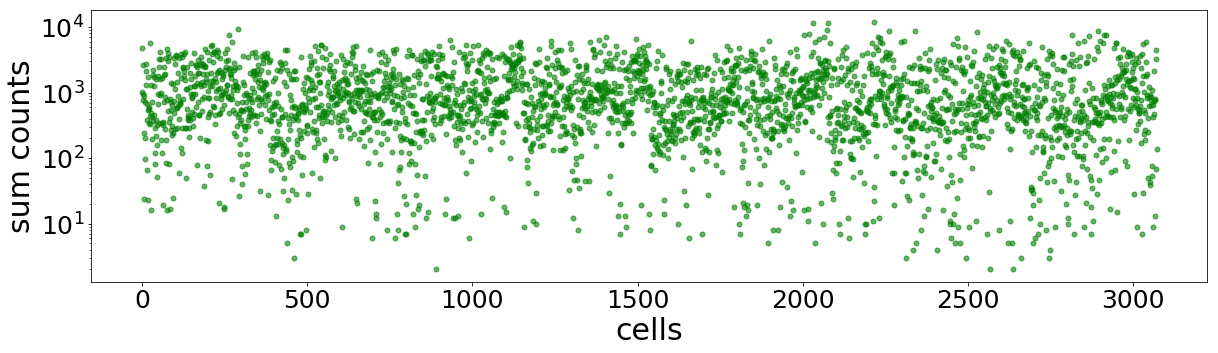

In [5]:
#all counts total
sums_cells = df.sum(axis=0)

plt.figure(figsize=(20,5))
ax = plt.gca()
ax.plot(range(len(sums_cells)), sums_cells, 'o', ms=5, color="green",alpha=0.6)
ax.set_yscale('log')
ax.set_xlabel('cells', fontsize=30); plt.ylabel('sum counts', fontsize=30)
ax.tick_params(labelsize=25)
plt.show()

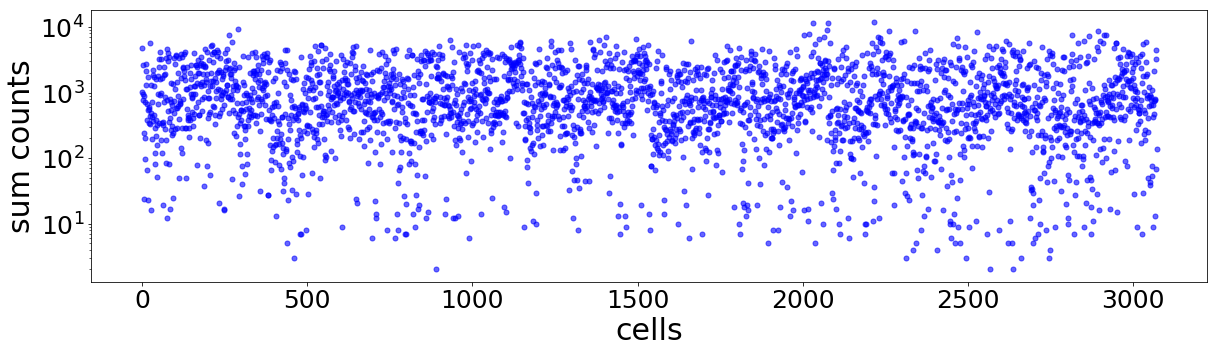

In [6]:
#all counts chr12
sums_cellsSF = sf.sum(axis=0)

plt.figure(figsize=(20,5))
ax = plt.gca()
ax.plot(range(len(sums_cellsSF)), sums_cellsSF, 'o', ms=5, color="blue",alpha=0.6)
ax.set_yscale('log')
ax.set_xlabel('cells', fontsize=30); plt.ylabel('sum counts', fontsize=30)
ax.tick_params(labelsize=25)
plt.show()

#### Check the total amount of counts per chromosome for all cells together

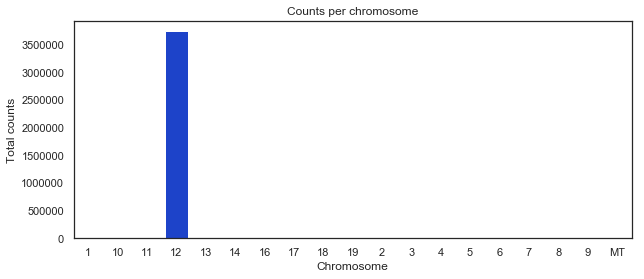

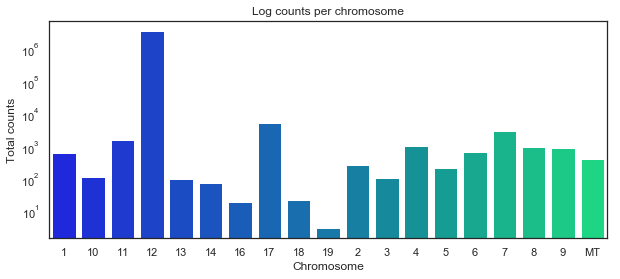

In [7]:
sns.set_context("talk", font_scale=5)

#Plot raw counts per chromosome
sums_cells = df.sum(axis=0, level=0)
countsPerChrom = sums_cells.sum(axis=1)
sns.set(style="white")
plt.figure(figsize=(10,4))
ax = sns.barplot(x=countsPerChrom.index, y=countsPerChrom,palette="winter")
ax.set(xlabel='Chromosome', ylabel='Total counts', title='Counts per chromosome')
plt.show()

sums_cells = df.sum(axis=0, level=0)
countsPerChrom = sums_cells.sum(axis=1)
sns.set(style="white")
plt.figure(figsize=(10,4))
ax = sns.barplot(x=countsPerChrom.index, y=countsPerChrom, log = 'y',palette="winter")
ax.set(xlabel='Chromosome', ylabel='Total counts',title='Log counts per chromosome')
plt.show()

#### Check the total amount of counts for each gRNA target site.
Green: Total amount of counts for each target site.
Orange: Amount of 129 reads for each target site.
Red: Amount of B6 reads for each target site.
Blue: Amount of reads not assigned to either allele for each target site.

In [8]:
sf.filter(regex=r'1147087', axis=0)

gastruloid                                                               C5A9  \
cell                                                                     A2_1   
allele      site      scar                                                      
129S1_SvImJ 114708745 114708785.D                                         NaN   
                      114708786.D                                         NaN   
                      114708787.D,114708788.D                             NaN   
                      114708787.D,114708788.D,114708789.D                 NaN   
                      114708788.D                                         NaN   
...                                                                       ...   
None        114708745 WT                                                  5.0   
            114788469 114708799.D,114708800.D,114708801.D,114708802.D...  NaN   
            114788571 114708799.D,114708800.D,114708801.D,114708802.D...  NaN   
            114788582 114708799.D,114708800.D,114708801.D,114708802.D...  NaN   
            114817194 114708789.D,114708790.D                             NaN   

gastruloid                                                                      \
cell                                                                     A2_10   
allele      site      scar                                                       
129S1_SvImJ 114708745 114708785.D                                          NaN   
                      114708786.D                                          NaN   
                      114708787.D,114708788.D                              NaN   
                      114708787.D,114708788.D,114708789.D                  NaN   
                      114708788.D                                          NaN   
...                                                                        ...   
None        114708745 WT                                                   NaN   
            114788469 114708799.D,114708800.D,114708801.D,114708802.D...   NaN   
            114788571 114708799.D,114708800.D,114708801.D,114708802.D...   NaN   
            114788582 114708799.D,114708800.D,114708801.D,114708802.D...   NaN   
            114817194 114708789.D,114708790.D                              NaN   

gastruloid                                                                       \
cell                                                                     A2_100   
allele      site      scar                                                        
129S1_SvImJ 114708745 114708785.D                                           NaN   
                      114708786.D                                           NaN   
                      114708787.D,114708788.D                               NaN   
                      114708787.D,114708788.D,114708789.D                   NaN   
                      114708788.D                                           NaN   
...                                                                         ...   
None        114708745 WT                                                    NaN   
            114788469 114708799.D,114708800.D,114708801.D,114708802.D...    NaN   
            114788571 114708799.D,114708800.D,114708801.D,114708802.D...    NaN   
            114788582 114708799.D,114708800.D,114708801.D,114708802.D...    NaN   
            114817194 114708789.D,114708790.D                               NaN   

gastruloid                                                                       \
cell                                                                     A2_101   
allele      site      scar                                                        
129S1_SvImJ 114708745 114708785.D                                           NaN   
                      114708786.D                                           NaN   
                      114708787.D,114708788.D                               NaN   
                      114708787.D,114708788.D,114708789

In [10]:
#calculate total amount of reads per site
sums_cells_all = pd.DataFrame(sf.sum(axis=0, level=1).sum(axis=1))

#calculate total amount of reads per site, allele-specific
sums_cells_129 = pd.DataFrame(sf_129.sum(axis=0, level=0).sum(axis=1))
sums_cells_B6 = pd.DataFrame(sf_B6.sum(axis=0, level=0).sum(axis=1))
sums_cells_nonallelic = pd.DataFrame(sf_nonallelic.sum(axis=0, level=0).sum(axis=1))

#merge
countspersite = pd.concat([sums_cells_B6,sums_cells_129,
                                  sums_cells_nonallelic, sums_cells_all], axis=1, sort=True)
countspersite.columns = ['B6', '129', 'NA', 'all']
countspersite = countspersite.fillna(0)

#select only scar sites
#selectedSites = countspersite.loc[['114682729','114708745','114723869',      '114740505','114746370','114788469',  '114851287','114879985', '114896335', '114914696']]

selectedSites = countspersite.sort_values(by='all',ascending=False)[0:10]


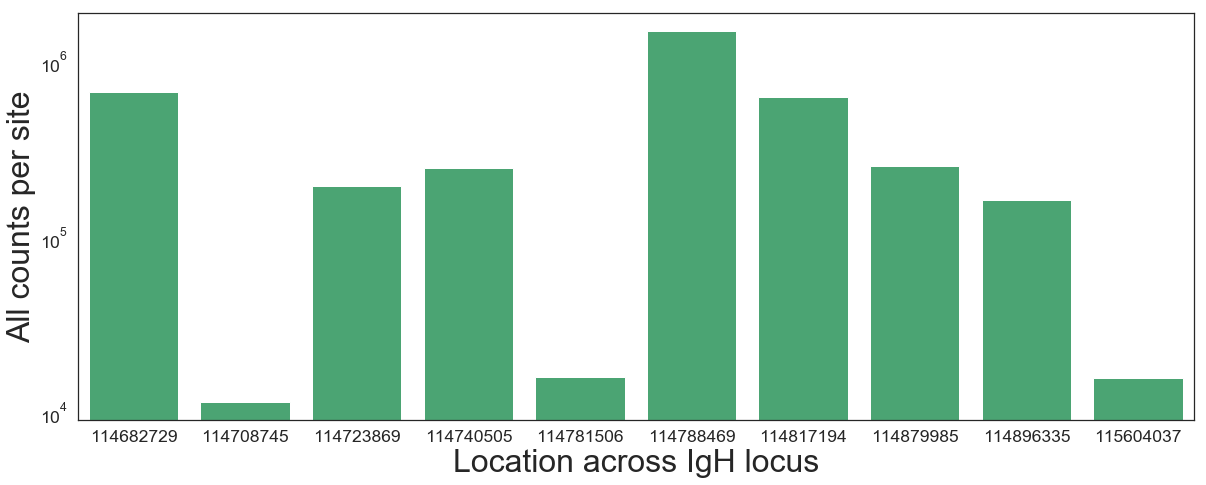

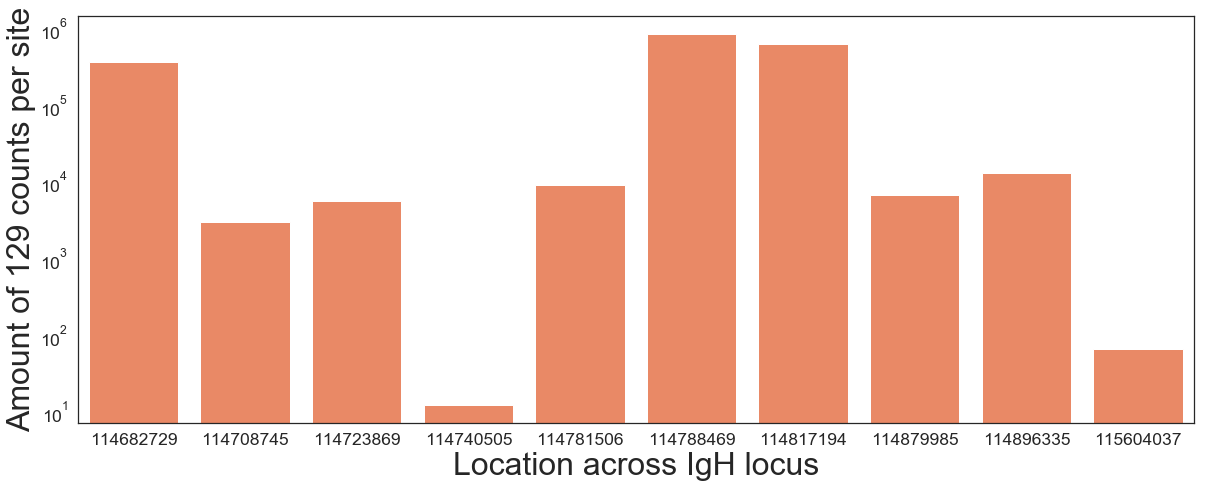

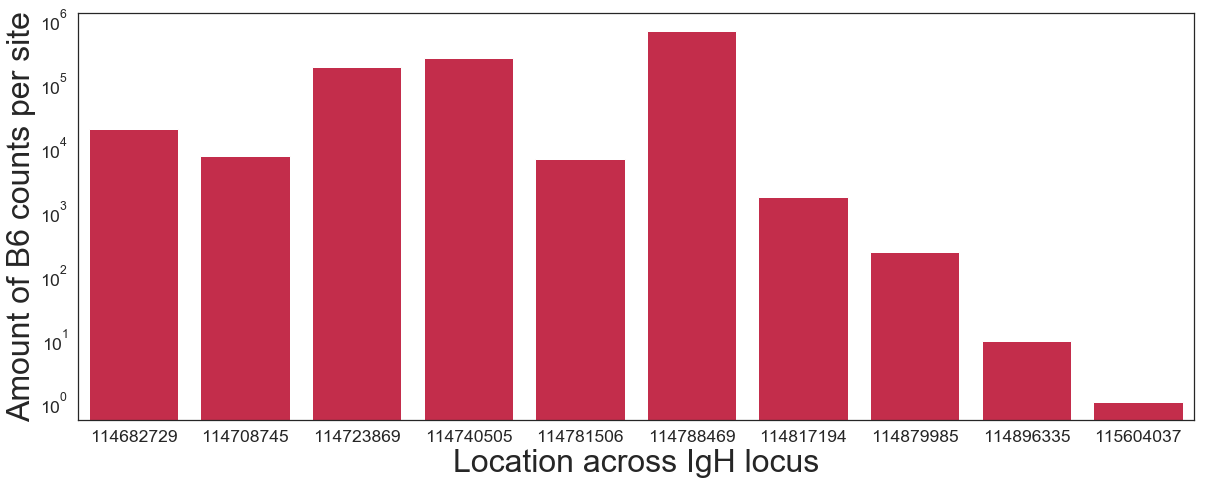

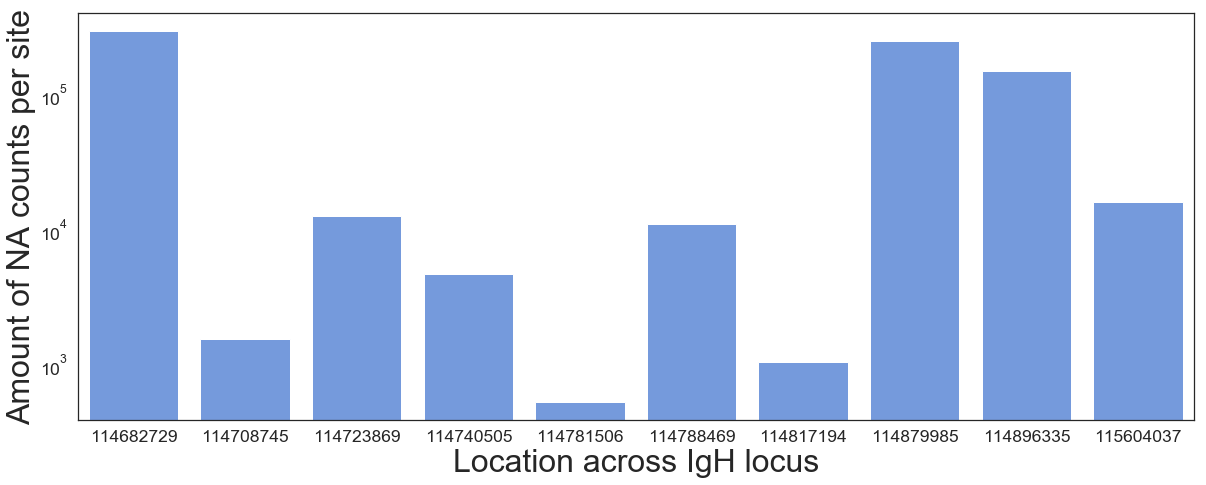

In [11]:
#plots
sns.set(style="white")
plt.figure(figsize=(20,7.5))
ax = sns.barplot(x=selectedSites.index, y=selectedSites['all'], log='y', color='mediumseagreen')
plt.xlabel('Location across IgH locus', fontsize=32); plt.ylabel('All counts per site', fontsize=32)
ax.tick_params(labelsize=17.5)
plt.show()

sns.set(style="white")
plt.figure(figsize=(20,7.5))
ax = sns.barplot(x=selectedSites.index, y=selectedSites['129'], log='y', color='coral')
ax.tick_params(labelsize=17.5)
plt.xlabel('Location across IgH locus', fontsize=32); plt.ylabel('Amount of 129 counts per site', fontsize=32)
plt.show()

sns.set(style="white")
plt.figure(figsize=(20,7.5))
ax = sns.barplot(x=selectedSites.index, y=selectedSites['B6'], log='y', color='crimson')
ax.tick_params(labelsize=17.5)
plt.xlabel('Location across IgH locus', fontsize=32); plt.ylabel('Amount of B6 counts per site', fontsize=32)
plt.show()

sns.set(style="white")
plt.figure(figsize=(20,7.5))
ax = sns.barplot(x=selectedSites.index, y=selectedSites['NA'], log='y', color='cornflowerblue')
ax.tick_params(labelsize=17.5)
plt.xlabel('Location across IgH locus', fontsize=32); plt.ylabel('Amount of NA counts per site', fontsize=32)
plt.show()

#### Total amount of reads per chromosome, for each gastruloid individually.

In [12]:
def plotChrCountsGastruloid (gastruloidname):
    sns.set(style="white", font_scale=1)
    plt.figure(figsize=(10,4))
    countsPerChrom = sums_cells[gastruloidname].sum(axis=1) 
    ax = sns.barplot(x=countsPerChrom.index, y=countsPerChrom, color='mediumblue')
    ax.set_title('Gastruloid' + str(gastruloidname))
    ax.set(xlabel='Chromosome', ylabel='Total counts')
    plt.show()

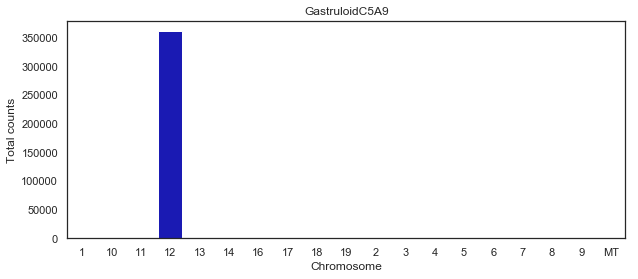

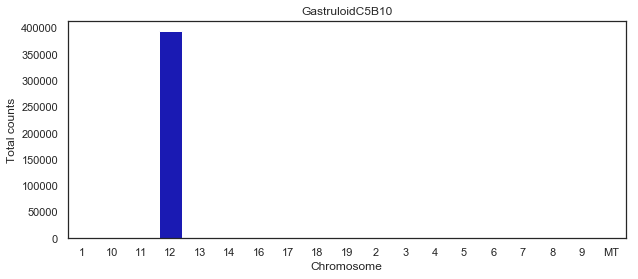

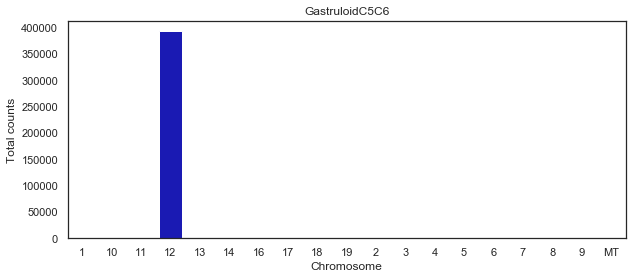

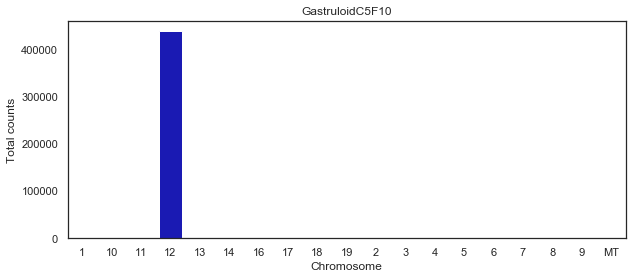

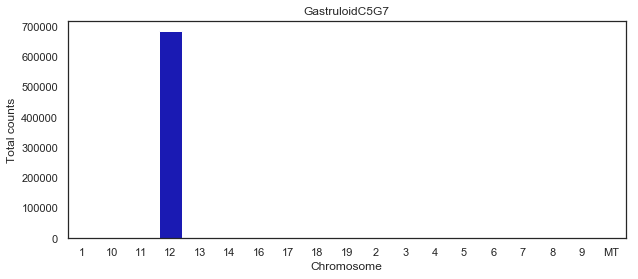

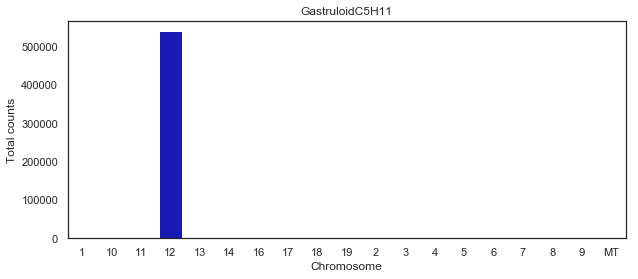

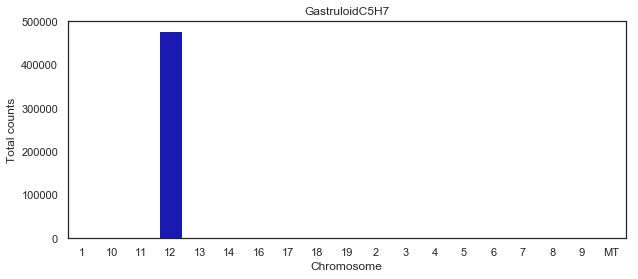

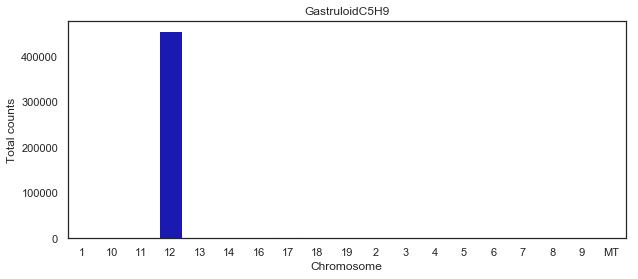

In [13]:
for gastruloid in df.columns.levels[0]:
    plotChrCountsGastruloid(gastruloid)

# Calculate percentages per allele for chromosome 12

#### This should only be necessary once. If this has been computed and saved already, move down to 'load computed datasets'.

here we also filter on the amount of reads per cell/site/allele by continuing when totalReadsForThisSite < 4.
To be considered for conversion to percentages, a cell/site/allele must contain 4 or more reads.

In [14]:
sitesB6 = []
sites129 = []
sitesNA = []
for (allele,site,scar) in sf.index:
    if allele == 'C57BL_6NJ':
        if site != 'None':
            if site not in sitesB6:
                sitesB6.append(site)
    if allele == '129S1_SvImJ':
        if site != 'None':
            if site not in sites129:
                sites129.append(site)
    if allele != 'C57BL_6NJ' and allele != '129S1_SvImJ' and allele !='129S1_SvImJ,C57BL_6NJ' :
        if site != 'None':
            if site not in sitesNA:
                sitesNA.append(site)

In [15]:
#129
sf_129 = sf_129.fillna(0)
cellToSiteToScarPercentage129 = collections.defaultdict(lambda: collections.defaultdict(collections.Counter ))
for gastruloid, cell in sf_129.columns:
    for site in sites129:
        if len(sf_129.loc[site]) < 4:
            continue
        totalReadsForThisSite = sf_129.loc[site, (gastruloid, cell)].sum()
        if totalReadsForThisSite < 4:
            continue
        for scar, amountOfReads in sf_129.loc[site,(gastruloid, cell)].iteritems():
            percentage = (amountOfReads / totalReadsForThisSite)*100.0
            if percentage > 5:
                cellToSiteToScarPercentage129[(gastruloid,cell)][int(site)][scar] += percentage

percentagesChrom12 = collections.defaultdict(dict) # (cell, gastruloid)->(site,scar)-> value (.. ,1,2)

for (cell, gastruloid), allSitesForThisCell in cellToSiteToScarPercentage129.items():
    for site, allScarsForThisSite in allSitesForThisCell.items():
        for scar, percentage in allScarsForThisSite.most_common(10):
            percentagesChrom12[(cell,gastruloid)][(site,scar)] = percentage

percentagesChr12_129 = pd.DataFrame(percentagesChrom12)

In [16]:
#B6
sf_B6 = sf_B6.fillna(0)
cellToSiteToScarPercentageB6 = collections.defaultdict(lambda: collections.defaultdict(collections.Counter ))
for gastruloid, cell in sf_B6.columns:
    for site in sitesB6:
        if len(sf_B6.loc[site]) < 4:
            continue
        totalReadsForThisSite = sf_B6.loc[site, (gastruloid, cell)].sum()
        if totalReadsForThisSite < 4:
            continue
        for scar, amountOfReads in sf_B6.loc[site,(gastruloid, cell)].iteritems():
            percentage = (amountOfReads / totalReadsForThisSite)*100.0
            if percentage > 5:
                cellToSiteToScarPercentageB6[(gastruloid,cell)][int(site)][scar] += percentage

percentagesChr12B6 = collections.defaultdict(dict) # (cell, gastruloid)->(site,scar)-> value (.. ,1,2)
for (cell, gastruloid), allSitesForThisCell in cellToSiteToScarPercentageB6.items():
    for site, allScarsForThisSite in allSitesForThisCell.items():
        for scar, percentage in allScarsForThisSite.most_common(10):
            percentagesChr12B6[(cell,gastruloid)][(site,scar)] = percentage

percentagesChr12_B6 = pd.DataFrame(percentagesChr12B6)

In [17]:
#nonallelic
sf_nonallelic = sf_nonallelic.fillna(0)                
cellToSiteToScarPercentageNA = collections.defaultdict(lambda: collections.defaultdict(collections.Counter ))
for gastruloid, cell in sf_nonallelic.columns:
    for site in sitesNA:
        if len(sf_nonallelic.loc[site]) < 4:
            continue
        totalReadsForThisSite = sf_nonallelic.loc[site, (gastruloid, cell)].sum()
        if totalReadsForThisSite < 4:
            continue
        for scar, amountOfReads in sf_nonallelic.loc[site,(gastruloid, cell)].iteritems():
            percentage = (amountOfReads / totalReadsForThisSite)*100.0
            if percentage > 5:
                cellToSiteToScarPercentageNA[(gastruloid,cell)][int(site)][scar] += percentage

percentagesChr12NA = collections.defaultdict(dict) # (cell, gastruloid)->(site,scar)-> value (.. ,1,2)
for (cell, gastruloid), allSitesForThisCell in cellToSiteToScarPercentageNA.items():
    for site, allScarsForThisSite in allSitesForThisCell.items():
        for scar, percentage in allScarsForThisSite.most_common(10):
            percentagesChr12NA[(cell,gastruloid)][(site,scar)] = percentage

percentagesChr12_NA = pd.DataFrame(percentagesChr12NA)

In [18]:
#to save dataframes
percentagesChr12_129.to_pickle(pathToData + '120hAA_dataFramepercentagesChr12_129.pickle.gz')
percentagesChr12_B6.to_pickle(pathToData + '120hAA_dataFramepercentagesChr12_B6.pickle.gz')
percentagesChr12_NA.to_pickle(pathToData + '120hAA_dataFramepercentagesChr12_NA.pickle.gz')

# Converting to allele counts

#### This should only be necessary once. If this has been computed and saved already, move down to 'load computed datasets'.

In [19]:
#For 129:
alleleCountsChr12_129 = collections.defaultdict(dict)
for (cell, gastruloid), allSitesForThisCell in cellToSiteToScarPercentage129.items():
    for site, allScarsForThisSite in allSitesForThisCell.items():
        for scar, percentage in allScarsForThisSite.most_common(2):
            if percentage > 55: 
                alleleCountsChr12_129[(cell,gastruloid)][(site,scar)] = 1

alleleCountsChr12_129PD = pd.DataFrame(alleleCountsChr12_129)

In [20]:
# For B6:
alleleCountsChr12_B6 = collections.defaultdict(dict)
for (cell, gastruloid), allSitesForThisCell in cellToSiteToScarPercentageB6.items():
    for site, allScarsForThisSite in allSitesForThisCell.items():
        for scar, percentage in allScarsForThisSite.most_common(2):
            if percentage > 55: 
                alleleCountsChr12_B6[(cell,gastruloid)][(site,scar)] = 1

alleleCountsChr12_B6PD = pd.DataFrame(alleleCountsChr12_B6)

In [21]:
#'allelecounts' non-allelic
alleleCountsChr12_NA = collections.defaultdict(dict)
for (cell, gastruloid), allSitesForThisCell in cellToSiteToScarPercentageNA.items():
    for site, allScarsForThisSite in allSitesForThisCell.items():
        for scar, percentage in allScarsForThisSite.most_common(2):
            if percentage > 55: 
                alleleCountsChr12_NA[(cell,gastruloid)][(site,scar)] = 2
            elif percentage > 30 and percentage < 55:
                alleleCountsChr12_NA[(cell,gastruloid)][(site,scar)] = 1

alleleCountsChr12_NAPD = pd.DataFrame(alleleCountsChr12_NA)        

In [22]:
#to save dataframes
alleleCountsChr12_129PD.to_pickle(pathToData + '120hAA_dataFrameAlleleCountsChr12_129.pickle.gz')
alleleCountsChr12_B6PD.to_pickle(pathToData + '120hAA_dataFrameAlleleCountsChr12_B6.pickle.gz')
alleleCountsChr12_NAPD.to_pickle(pathToData + '120hAA_dataFrameAlleleCountsChr12_NA.pickle.gz')

# Make dataframes for sparse distance matrix (IWSS) clustering

#### This should only be necessary once. If this has been computed and saved already, move down to 'load computed datasets'.

In [24]:
targetsites = [114682729, 114708745, 114723869, 114740505,114746370, 114788469, 114843748, 114851287,
          114879985,114896335,114910108,114914696]

In [25]:
targetsites129 = []
targetsitesB6 = []
targetsitesNA = []
for site in targetsites:
    for index in alleleCountsChr12_129PD.index.levels[0]:
        if site == index:
            targetsites129.append(site)
    for index in alleleCountsChr12_B6PD.index.levels[0]:
        if site == index:
            targetsitesB6.append(site)
    for index in alleleCountsChr12_NAPD.index.levels[0]:
        if site == index:
            targetsitesNA.append(site)

In [26]:
allelecounts129_ts = alleleCountsChr12_129PD.loc[targetsites129]
allelecountsB6_ts = alleleCountsChr12_B6PD.loc[targetsitesB6]
allelecountsNA_ts = alleleCountsChr12_NAPD.loc[targetsitesNA]

In [27]:
allelecountsNA_ts.index = ['NA_' + str(site) for site in allelecountsNA_ts.index]
allelecountsB6_ts.index = ['B6_' + str(site) for site in allelecountsB6_ts.index]
allelecounts129_ts.index = ['129_' + str(site) for site in allelecounts129_ts.index]

In [28]:
dfs = [allelecountsNA_ts,allelecountsB6_ts,allelecounts129_ts]
all_allelecounts_fordistancecalc = pd.concat(dfs)

In [29]:
#to save 
all_allelecounts_fordistancecalc.to_pickle(pathToData + '120hAA_all_allelecounts_fordistancecalc.pickle.gz')
allelecountsNA_ts.to_pickle(pathToData + '120hAA_allelecountsNA_ts.pickle.gz')
allelecountsB6_ts.to_pickle(pathToData + '120hAA_allelecountsB6_ts.pickle.gz')
allelecounts129_ts.to_pickle(pathToData + '120hAA_allelecounts129_ts.pickle.gz')

# Making 'heatmap' dataframes for Buys' heatmap plotting

#### This should only be necessary once. If this has been computed and saved already, move down to 'load computed datasets'.

In [30]:
# for 129
alleleCountsChr12_129PD
heatmapAllele_129 = alleleCountsChr12_129PD.copy()
heatmapAlleleCounts_129 = collections.defaultdict(dict)
for (gastruloid, cell), allSitesForThisCell in heatmapAllele_129.items():
    for (site, scar), allelecounts in allSitesForThisCell.items():
        if allelecounts == 1.0:
            heatmapAlleleCounts_129[('129, ' + str(site))][(gastruloid,cell)] = scar
            
heatmapAlleleCounts_129Pd = pd.DataFrame(heatmapAlleleCounts_129)

In [31]:
# for B6
alleleCountsChr12_B6PD
heatmapAlleleCounts_B6 = collections.defaultdict(dict)
for (gastruloid, cell), allSitesForThisCell in alleleCountsChr12_B6PD.items():
    for (site, scar), allelecounts in allSitesForThisCell.items():
        if allelecounts == 1.0:
            heatmapAlleleCounts_B6[('B6, ' + str(site))][(gastruloid,cell)] = scar

heatmapAlleleCounts_B6PD = pd.DataFrame(heatmapAlleleCounts_B6)

In [32]:
#nonallelic
heatmap_nonallelic = collections.defaultdict(dict)

for (gastruloid, cell), allSitesForThisCell in alleleCountsChr12_NAPD.items():
    for (site, scar), allelecounts in allSitesForThisCell.items():
        if allelecounts == 2.0:
            heatmap_nonallelic[('nonallelic, ' + str(site))][(gastruloid,cell)] = scar
            
heatmap_nonallelicPD = pd.DataFrame(heatmap_nonallelic)

In [33]:
dfs_all = [heatmapAlleleCounts_129Pd,heatmapAlleleCounts_B6PD,heatmap_nonallelicPD]
heatmap = dfs_all[0].join(dfs_all[1:],how='outer')

In [34]:
heatmapAlleleCounts_129Pd.to_pickle(pathToData + '120hAA_dataframeForHeatmap_All_129.pickle.gz')
heatmapAlleleCounts_B6PD.to_pickle(pathToData + '120hAA_dataframeForHeatmap_All_B6.pickle.gz')
heatmap_nonallelicPD.to_pickle(pathToData + '120hAA_dataframeForHeatmap_All_nonallelic.pickle.gz')
heatmap.to_pickle(pathToData + '120hAA_dataframeForHeatmap_All.pickle.gz')